# Simple RNN

In ths notebook, I am going to train a simple RNN to do **time-series prediction**. Given some set of input data, it would generate a prediction for the next time step!
<img src='assets/time_prediction.png' width=40% />

> * First, I'll create my data
* Then, define an RNN in PyTorch
* Finally, I'll train my network and see how it performs

### Import resources and create data 

In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

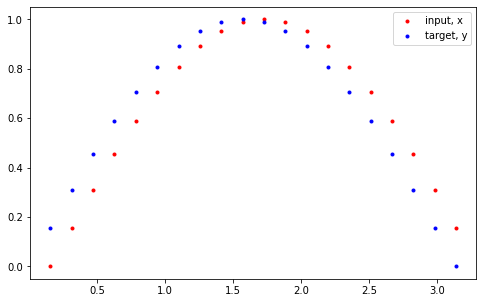

In [ ]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 20

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [ ]:
data

array([[0.00000000e+00],
       [1.56434465e-01],
       [3.09016994e-01],
       [4.53990500e-01],
       [5.87785252e-01],
       [7.07106781e-01],
       [8.09016994e-01],
       [8.91006524e-01],
       [9.51056516e-01],
       [9.87688341e-01],
       [1.00000000e+00],
       [9.87688341e-01],
       [9.51056516e-01],
       [8.91006524e-01],
       [8.09016994e-01],
       [7.07106781e-01],
       [5.87785252e-01],
       [4.53990500e-01],
       [3.09016994e-01],
       [1.56434465e-01],
       [1.22464680e-16]])

---
## Defining the RNN

Next, I define an RNN in PyTorch. I'll use `nn.RNN` to create an RNN layer, then I'll add a last, fully-connected layer to get the output size that I want i.e in this case my output size is equal to 1. An RNN takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        
        # shape output to be (batch_size*seq_length, hidden_dim)
        # print("output before squeeshed {}".format(r_out.shape))
        r_out = r_out.view(-1, self.hidden_dim)  
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden


---
## Training the RNN

Next, I'll instantiate an RNN with some specified hyperparameters. Then train it over a series of steps, and see how it performs.

In [ ]:
# decide on hyperparameters
input_size=1
output_size=1
hidden_dim=20
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)


### Loss and Optimization

In [ ]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

### Defining the training function


In [ ]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # print("Input tensor shape {}".format(x_tensor.shape))
        
        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn


Loss:  0.19150756299495697


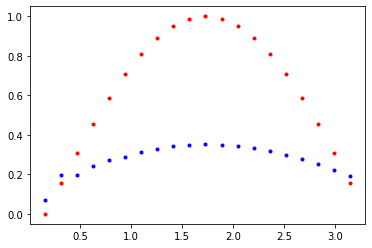

Loss:  0.04115244001150131


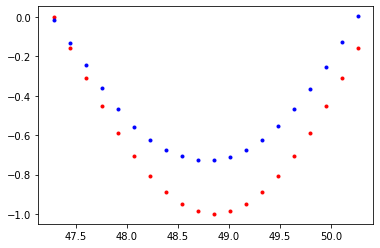

Loss:  0.0013636285439133644


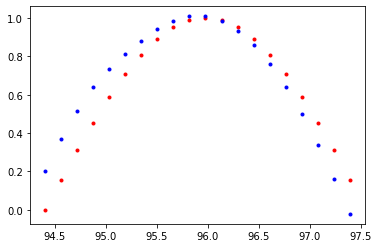

Loss:  0.0015194981824606657


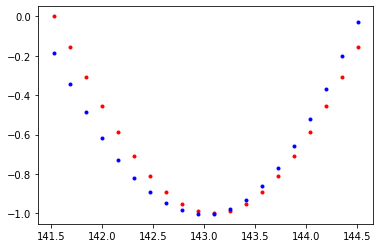

Loss:  0.0004940871731378138


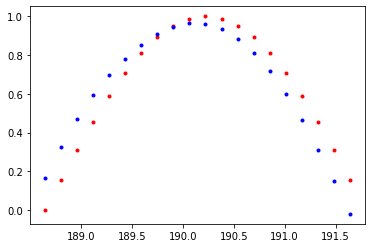

In [ ]:
# train the rnn and monitor results
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)